<a href="https://colab.research.google.com/github/yuyinglu2000/Sepsis-Mortality/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Improving Prediction Accuracy of Sepsis Mortality using Natural Language Processing
## Tyler Kelly
# Sepsis Model Training

# Purpose

The purpose of this file is to perform a machine learning pipeline to train and test preprocessed sepsis data. 

First, I determine the best model using the 'data_after_cleaning' dataset (featuring 48 features and a sample size of 5209) and test the same models used in the author's paper:

    SVC,
    DecisionTree,
    RandomForest,
    GradientBoosting,
    MLP,
    XGB,
    LGBM
    
and compare model accuracy, AUC/ROC, F1, F2, precision, precision and recall, and provide 95% CI as in the original paper.

Second, I then perform side-by-side comparison of these metrics against the same dataset including NLP word embeddings. I provide side-by-side figures to highlight main differences in the models using the different feature spaces, and showcase important differences in accuracy and AUROC.

Third, I display feature importances and further incorporate SHAP values into the pipeline similar to how the author's did. The SHAP values are incorporated because ____

Fourth, I perform chi-square statistical tests to compare ___.

Finally, I perform statistical tests to compare if there is a statistically significant difference in model performance between the best performing model for each feature space. By doing so, and determining Cohen's d for effect size, I can roughly approximate how much more one model improves. Then, I attempt to address through discussion possible entry points for noise, which could falsely inflate model accuracy and AUROC on the testing set.

# Note

This file is a continuation of 'pymain.ipynb'. In pymain step 4 (done in R), word2vec embeddings are developed and appended to the nlp_ready_df dataframe. They are saved as 

'data_w2v_radiology_old.csv' and 
'data_w2v_combined_old.csv' 

and are imported below.

Currently, these dataframes represent the old dataset. After the sql is fixed, remove _old

### The following code is adapted from the github repository 'https://github.com/yuyinglu2000/Sepsis-Mortality'

It is marked with #AC when primarily using the author's code, and unmarked when it is my own.

# Import Packages

In [3]:
#AC

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb

# Import Data

## Import Original and W2V Data

I begin Model Training by first ensuring that my embeddings are standardized as it was recommended by chat gpt

**NOTE** I may need to scale other numeric variables too, but **AM NOT DOING THAT** right now.

Chatgpt prompt: Show how to Scale embeddings before using in ML: from sklearn.preprocessing import StandardScaler

Output:

"Sure! In Python, if you're using Word2Vec embeddings (like w2v_1, w2v_2, ..., w2v_100) as features for machine learning, it's important to scale them, especially if you're using models like logistic regression, SVM, or neural networks.

You can do this using StandardScaler from sklearn.preprocessing."

**NOTE** Further, only the w2v patient vectors are scaled.

In [4]:
# Read in w2v modified dataset
df = pd.read_csv('Data/Old/data_after_cleaning.csv')

df_w2v = pd.read_csv('Data/Old/W2V_old/data_w2v_radiology_old.csv')

#df = pd.read_csv('data_w2v_radiology.csv') remove _old when sql is fixed and rerun entire document, changing save file names along the way

In [5]:
# Check to make sure dataset is correct
df.head()

,subject_id,hospital_expire_flag,max_age,los_icu,first_hosp_stay,suspected_infection,sofa_score,sepsis3,avg_urineoutput,glucose_min,...,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
0,19986715,0,24,10.58,True,1,2,True,136.657143,82,...,0,0,0,1,0,0,0,0,1,0
1,19973083,0,58,2.33,True,1,8,True,34.263158,94,...,0,0,0,1,0,0,0,0,1,0
2,19907774,1,65,1.83,True,1,2,True,105.476191,65,...,0,0,0,1,0,0,0,0,1,0
3,19894745,1,76,1.08,True,1,4,True,34.000000,267,...,0,0,0,1,0,0,0,0,1,0
4,19884808,1,64,20.46,True,1,5,True,107.229508,146,...,0,0,0,1,0,0,0,0,1,0


In [4]:
df_w2v.head()

,subject_id,hospital_expire_flag,max_age,los_icu,first_hosp_stay,suspected_infection,sofa_score,sepsis3,avg_urineoutput,glucose_min,...,w2v_rad_91,w2v_rad_92,w2v_rad_93,w2v_rad_94,w2v_rad_95,w2v_rad_96,w2v_rad_97,w2v_rad_98,w2v_rad_99,w2v_rad_100
0,19986715,0,24,10.58,True,1,2,True,136.657143,82,...,0.054860,-0.134476,0.010113,0.138862,-0.164830,0.010343,-0.004907,-0.059874,-0.104063,0.045992
1,19973083,0,58,2.33,True,1,8,True,34.263158,94,...,0.016587,-0.109384,0.119165,0.184869,-0.054834,0.005417,-0.094042,-0.079441,-0.029285,0.016895
2,19907774,1,65,1.83,True,1,2,True,105.476191,65,...,-0.080038,-0.117593,-0.005822,0.107834,-0.079289,0.127771,-0.030650,-0.005073,-0.121476,0.020389
3,19894745,1,76,1.08,True,1,4,True,34.000000,267,...,-0.061370,-0.187079,-0.034887,0.117981,-0.085173,0.077792,-0.034223,-0.060790,-0.179078,-0.021921
4,19884808,1,64,20.46,True,1,5,True,107.229508,146,...,-0.080242,-0.085314,-0.076269,0.158099,-0.055382,0.081583,0.066497,-0.041396,-0.131663,-0.093858


## Standard Scaling of w2v vectors

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# df contains both features and w2v columns, and 'subject_id'
# Step 1: Select the Word2Vec columns
w2v_cols = [col for col in df_w2v.columns if col.startswith("w2v_") or col.startswith("rad_w2v_")]

# Step 2: Initialize the scaler
scaler = StandardScaler()

# Step 3: Fit and transform the embeddings
scaled_embeddings = scaler.fit_transform(df_w2v[w2v_cols])

# Step 4: Replace or store the scaled version in a new DataFrame
scaled_w2v = pd.DataFrame(scaled_embeddings, columns=w2v_cols)
scaled_w2v["subject_id"] = df_w2v["subject_id"].values  # reattach subject_id

# Step 5 (Optional): Merge scaled embeddings back into main dataset
# Drop the original embeddings first to avoid duplication
scaled_w2v = df_w2v.drop(columns=w2v_cols).merge(scaled_w2v, on="subject_id", how="left")


In [6]:
scaled_w2v.to_csv('Data/Old/W2V_old/data_w2v_radiology_old_scaled.csv', index=False)

In [7]:
print(scaled_w2v.columns.values)

['subject_id' 'hospital_expire_flag' 'max_age' 'los_icu' 'first_hosp_stay'
 'suspected_infection' 'sofa_score' 'sepsis3' 'avg_urineoutput'
 'glucose_min' 'glucose_max' 'glucose_average' 'sodium_max' 'sodium_min'
 'sodium_average' 'diabetes_without_cc' 'diabetes_with_cc'
 'severe_liver_disease' 'aids' 'renal_disease' 'heart_rate_min'
 'heart_rate_max' 'heart_rate_mean' 'sbp_min' 'sbp_max' 'sbp_mean'
 'dbp_min' 'dbp_max' 'dbp_mean' 'resp_rate_min' 'resp_rate_max'
 'resp_rate_mean' 'spo2_min' 'spo2_max' 'spo2_mean' 'coma' 'albumin'
 'race_Black or African American' 'race_Hispanic or Latin'
 'race_Others race' 'race_White' 'antibiotic_Vancomycin'
 'antibiotic_Vancomycin Antibiotic Lock' 'antibiotic_Vancomycin Enema'
 'antibiotic_Vancomycin Intrathecal' 'antibiotic_Vancomycin Oral Liquid'
 'gender_F' 'gender_M' 'Discharge_summary_notes' 'Radiology_notes'
 'combined_notes' 'w2v_rad_1' 'w2v_rad_2' 'w2v_rad_3' 'w2v_rad_4'
 'w2v_rad_5' 'w2v_rad_6' 'w2v_rad_7' 'w2v_rad_8' 'w2v_rad_9' 'w2v_rad_10

## Import BERT Models

Set Paths and Models

In [ ]:
import os
import joblib
import pandas as pd

cache_dir = "BERT/BERT_cache"
bert_models = [
    'emilyalsentzer/Bio_ClinicalBERT',
    'dmis-lab/biobert-base-cased-v1.2',
    'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
]

Load Merged Patient Level Embeddings

In [ ]:
merged_dfs = {}

for model_name in bert_models:
    agg_cache_path = os.path.join(cache_dir, f"patient_agg_{model_name.replace('/', '_')}.pkl")
    
    if os.path.exists(agg_cache_path):
        print(f"Loading patient-level embeddings for {model_name}...")
        merged_df = joblib.load(agg_cache_path)
        merged_dfs[model_name] = merged_df
    else:
        print(f"⚠️ Cache not found for {model_name}, run full workflow first.")

### Clinical BERT Dataset

In [ ]:
clinical_bert = 

### BioBERT Dataset

In [ ]:
bio_bert = 

### Clinical+Bio BERT Dataset

In [ ]:
clinbio_bert =

# Model Training

Here, I generally follow the pipeline designed in the author's github. I do this to provide side by side comparison of my ML pipeline vs theirs.

When necessary, I include 'w/ edits' at the top of a code block to denote minor edits I make to the author's code.

## Define Feature Space and Predictor Variable

### Original Feature Space & Predictor

Below is the code the authors used to define X and y for model training.

In [7]:
# AC
X = df.drop(columns=['hospital_expire_flag','subject_id','first_hosp_stay','suspected_infection','sepsis3'])
y = df['hospital_expire_flag']

In [ ]:
X

### W2V Feature Space & Predictor

In [8]:
# AC w/ edits

X_w2v = scaled_w2v.drop(columns=['hospital_expire_flag','subject_id','first_hosp_stay','suspected_infection','sepsis3', 'Discharge_summary_notes', 'Radiology_notes', 'combined_notes'])
y_w2v = scaled_w2v['hospital_expire_flag']

In [ ]:
X_w2v

### Clinical BERT Feature Space & Predictor

In [ ]:
X_clin_bert = 

In [ ]:
y_clin_bert = 

### BioBERT Feature Space & Predictor

In [ ]:
X_bio_bert =

In [ ]:
y_bio_bert =

### Bio + Clinical BERT Feature Space & Predictor

In [ ]:
X_clinbio_bert =

In [ ]:
y_clinbio_bert =

## Train Test Split Data

# **MAJOR NOTE**

The data here does not currently have demographic data stratified. I will need to update the stratification process prior to data splitting to ensure that the data is correctly balanced, or at least make sure that is the case for w2v_improved and the BERT models.

# MAJOR NOTE 2

The author's used a method with SMOTE that is not used in best practice.

Chatgpt:

Best practice suggestion:

Instead of doing SMOTE before the train/test split, it's usually better to do:

In [ ]:
'''
# ChatGpt suggestion
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# This avoids introducing synthetic samples into your test set, which could inflate performance metrics.

'''

### Apply SMOTE for Imbalanced Data

### Author's Smote Code

In [ ]:
# AC
'''

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

'''


Using smote prior to model training causes data leakage. Information from the test set leaks into training, skewing model accuracy and inflating results. To account for this I chose to take a different approach at this step, choosing to perform train/test split before applying smote.

It becomes much harder to make fair comparisons after this since the models are trained, validated, and tested differently.

However, my results should be more robust as it follows best practice.

### tts_dataset_with_smote Function

I prompt engineer a function to be able to accept multiple dataframes so I don't need to redefine the T/T/S each time.

The test/train/smote_train arrays are returned and below defined separately for each dataset.

Technically x_train_smote and y_train_smote won't be used because I'm not doing a single holdout test. Since I am performing RepeatedStratifiedKFold cv, smote is performed inside the training folds to reduce information leakage.

However, in the event I do choose to use single holdout because the work gets to intense, it is an easy fall back here.

In [9]:
# from chatgpt
# Includes AC in function wrapper

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def tts_dataset_with_smote(X, y, test_size=0.2, random_state=42):
    """
    Apply SMOTE resampling to a single (X, y) dataset.
    
    Parameters:
        X: features (array-like or DataFrame)
        y: labels (array-like or Series)
        test_size: float (default=0.2)
            Fraction of dataset to allocate to the test split.
        random_state: int (default=42)
            Seed for reproducibility.
    
    Returns:
        dict containing:
            - X_train: original train features
            - X_test: test features
            - y_train: original train labels
            - y_test: test labels
            - X_train_smote: SMOTE-resampled train features
            - y_train_smote: SMOTE-resampled train labels
    """
    smote = SMOTE(random_state=random_state)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Apply SMOTE only to training set
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_smote": X_train_smote,
        "y_train_smote": y_train_smote
    }

### Original Data TTS

In [10]:
original_tts = tts_dataset_with_smote(X, y)

X_train, X_test = original_tts["X_train"], original_tts["X_test"]
y_train, y_test = original_tts["y_train"], original_tts["y_test"]

X_train_smote, y_train_smote = original_tts["X_train_smote"], original_tts["y_train_smote"]

### Word 2 Vec Data TTS

In [11]:
w2v_tts = tts_dataset_with_smote(X_w2v, y_w2v)

X_train_w2v, X_test_w2v = w2v_tts["X_train"], w2v_tts["X_test"]
y_train_w2v, y_test_w2v = w2v_tts["y_train"], w2v_tts["y_test"]

X_train_smote_w2v, y_train_smote_w2v = w2v_tts["X_train_smote"], w2v_tts["y_train_smote"]

### Word 2 Vec Stratified Data TTS

In [ ]:
'''
w2v_tts_strat = tts_dataset_with_smote(X_w2v_strat, y_w2v_strat)

X_train_w2v_strat, X_test_w2v_strat = w2v_tts_strat["X_train"], w2v_tts_strat["X_test"]
y_train_w2v_strat, y_test_w2v_strat = w2v_tts_strat["y_train"], w2v_tts_strat["y_test"]

X_train_smote_w2v_strat, y_train_smote_w2v_strat = w2v_tts_strat["X_train_smote"], w2v_tts_strat["y_train_smote"]
'''

### Clinical BERT TTS

In [ ]:
'''
clin_bert_tts = tts_dataset_with_smote(X_clin_bert, y_clin_bert)

X_train_clin_bert, X_test_clin_bert = clin_bert_tts["X_train"], clin_bert_tts["X_test"]
y_train_clin_bert, y_test_clin_bert = clin_bert_tts["y_train"], clin_bert_tts["y_test"]

X_train_smote_clin_bert, y_train_smote_clin_bert = clin_bert_tts["X_train_smote"], clin_bert_tts["y_train_smote"]
'''

### Bio BERT TTS

In [ ]:
'''
bio_bert_tts = tts_dataset_with_smote(X_bio_bert, y_bio_bert)

X_train_bio_bert, X_test_bio_bert = bio_bert_tts["X_train"], bio_bert_tts["X_test"]
y_train_bio_bert, y_test_bio_bert = bio_bert_tts["y_train"], bio_bert_tts["y_test"]

X_train_smote_bio_bert, y_train_smote_bio_bert = bio_bert_tts["X_train_smote"], bio_bert_tts["y_train_smote"]
'''

### Clinical Bio BERT TTS

In [ ]:
'''
clinbio_bert_tts = tts_dataset_with_smote(X_clinbio_bert, y_clinbio_bert)

X_train_clinbio_bert, X_test_clinbio_bert = clinbio_bert_tts["X_train"], clinbio_bert_tts["X_test"]
y_train_clinbio_bert, y_test_clinbio_bert = clinbio_bert_tts["y_train"], clinbio_bert_tts["y_test"]

X_train_smote_clinbio_bert, y_train_smote_clinbio_bert = clinbio_bert_tts["X_train_smote"], clinbio_bert_tts["y_train_smote"]
'''

## Check SMOTE training sets

In [ ]:
X_train_smote

In [ ]:
X_train_smote_w2v

## Plotting Count of Ones

In [13]:
# AC

import matplotlib.pyplot as plt
import seaborn as sns
count_of_ones = y.sum()

count_of_ones

1203

The authors chose to plot count of ones to affirm that SMOTE was appropriate

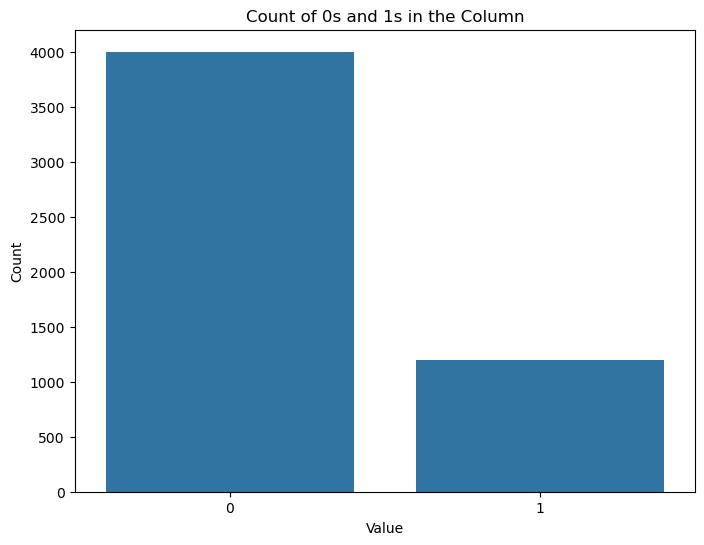

In [14]:
# AC w/ edits

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y' is your column and 'df' is your DataFrame
total_rows = len(df)
count_of_ones = y.sum()
count_of_zeros = total_rows - count_of_ones

# Preparing data for the bar chart
data = {'Count': [count_of_zeros, count_of_ones], 'Value': ['0', '1']}

# Creating the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Value', y='Count', data=data)
plt.title('Count of 0s and 1s in the Column')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


# Model Metrics and Selection

## Import and Instantiate Classifiers

A dictionary of the classifiers described in the introduction section of this file is created, instantiating instances of each of the classifier classes, utilizing the same hyperparameters as the authors.

In [12]:
# AC

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

classifiers = {
    'SVC': SVC(probability=True, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'XGB': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

Above we see that the authors chose to use logloss as the evaluation metric for extreme gradient boosting.

## Determining Model Metrics - Training and Test Data

# **NOTE**

The below blocks perform training/testing accuracy on non-cross validated data. It might not be worth running this / including it in results, its more for getting initial insights to accuracy before validation.

The authors used the below code to compare model metrics across the different machine learning classifiers for printing test only metrics.

In [ ]:
'''
# AC

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    return 5 * (precision * recall) / ((4 * precision) + recall)

# Iterating through each classifier
for name, clf in classifiers.items():
    # Fit model
    clf.fit(X_train, y_train)

    # Predict probabilities and labels
    y_scores_test = clf.predict_proba(X_test)[:, 1]
    y_pred_binary = (y_scores_test > 0.5).astype(int)

    # Calculate metrics
    auc_test = roc_auc_score(y_test, y_scores_test)
    accuracy_test = accuracy_score(y_test, y_pred_binary)
    f1_test = f1_score(y_test, y_pred_binary)
    precision_test = precision_score(y_test, y_pred_binary)
    recall_test = recall_score(y_test, y_pred_binary)
    f2_test = f2_score(precision_test, recall_test)

    # Print results
    print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
          f"F1 Score = {f1_test:.4f}, Precision = {precision_test:.4f}, "
          f"Recall = {recall_test:.4f}, F2 Score = {f2_test:.4f}")
'''

### Function wrapper for Initial Test AUC

I prompt engineer the following wrapper function. This allows not having to concisely pass different train/test data from the different models to get differing AUC scores

In [16]:
# Chatgpt output using AC inside

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    return 5 * (precision * recall) / ((4 * precision) + recall) if (precision + recall) > 0 else 0.0

def evaluate_classifiers_test(classifiers, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Train and evaluate multiple classifiers on given data.
    
    Parameters:
    -----------
    classifiers : dict
        Dictionary of {name: classifier} to evaluate.
    X_train, y_train : array-like
        Training features and labels.
    X_test, y_test : array-like
        Test features and labels.
    threshold : float, optional (default=0.5)
        Probability threshold to convert scores to binary predictions.
        
    Returns:
    --------
    results : dict
        Dictionary of metrics per classifier.
    """
    
    results = {}

    for name, clf in classifiers.items():
        # Fit model
        clf.fit(X_train, y_train)

        # Predict probabilities and labels
        y_scores_test = clf.predict_proba(X_test)[:, 1]
        y_pred_binary = (y_scores_test > threshold).astype(int)

        # Calculate metrics
        auc_test = roc_auc_score(y_test, y_scores_test)
        accuracy_test = accuracy_score(y_test, y_pred_binary)
        f1_test = f1_score(y_test, y_pred_binary)
        precision_test = precision_score(y_test, y_pred_binary)
        recall_test = recall_score(y_test, y_pred_binary)
        f2_test = f2_score(precision_test, recall_test)

        # Save metrics
        results[name] = {
            "AUC": auc_test,
            "Accuracy": accuracy_test,
            "F1": f1_test,
            "Precision": precision_test,
            "Recall": recall_test,
            "F2": f2_test
        }

        # Print results
        print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
              f"F1 = {f1_test:.4f}, Precision = {precision_test:.4f}, "
              f"Recall = {recall_test:.4f}, F2 = {f2_test:.4f}")
    
    return results


#### Original Dataset Initial Test AUC

In [ ]:
evaluate_classifiers_test(classifiers, X_train, y_train, X_test, y_test);

#### W2V Dataset Initial Test AUC

In [ ]:
evaluate_classifiers_test(classifiers, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v);

### F2 score and Defining Function to accept training and testing data

The author's then use a similar code chunk (below) to predict probabilities and labels on both train and test datasets. Since this one is more informative, I also create a wrapper function to accept the different models train/test data to be passed in.

In [ ]:
'''

# AC

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    return 5 * (precision * recall) / ((4 * precision) + recall)

# Iterating through each classifier
for name, clf in classifiers.items():
    # Fit model on training data
    clf.fit(X_train, y_train)

    # Predict probabilities and labels for both train and test datasets
    y_scores_train = clf.predict_proba(X_train)[:, 1]
    y_pred_binary_train = (y_scores_train > 0.5).astype(int)

    y_scores_test = clf.predict_proba(X_test)[:, 1]
    y_pred_binary_test = (y_scores_test > 0.5).astype(int)

    # Calculate metrics for train dataset
    auc_train = roc_auc_score(y_train, y_scores_train)
    accuracy_train = accuracy_score(y_train, y_pred_binary_train)
    f1_train = f1_score(y_train, y_pred_binary_train)
    precision_train = precision_score(y_train, y_pred_binary_train)
    recall_train = recall_score(y_train, y_pred_binary_train)
    sensitivity_train = recall_train  # Sensitivity is the same as Recall
    f2_train = f2_score(precision_train, recall_train)

    # Calculate metrics for test dataset
    auc_test = roc_auc_score(y_test, y_scores_test)
    accuracy_test = accuracy_score(y_test, y_pred_binary_test)
    f1_test = f1_score(y_test, y_pred_binary_test)
    precision_test = precision_score(y_test, y_pred_binary_test)
    recall_test = recall_score(y_test, y_pred_binary_test)
    sensitivity_test = recall_test  # Sensitivity is the same as Recall
    f2_test = f2_score(precision_test, recall_test)

    # Print results for both train and test datasets
    print(f"{name}: Train AUC = {auc_train:.4f}, Train Accuracy = {accuracy_train:.4f}, "
          f"Train F1 Score = {f1_train:.4f}, Train Precision = {precision_train:.4f}, "
          f"Train Recall = {recall_train:.4f}, Train Sensitivity = {sensitivity_train:.4f}, Train F2 Score = {f2_train:.4f}")

    print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
          f"Test F1 Score = {f1_test:.4f}, Test Precision = {precision_test:.4f}, "
          f"Test Recall = {recall_test:.4f}, Test Sensitivity = {sensitivity_test:.4f}, Test F2 Score = {f2_test:.4f}")


'''

Below I wrap the author's  code in a wrapper function to accept multiple model types

In [18]:
# From chatgpt
# Includes AC in function wrapper

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    """Custom F2 score definition."""
    return 5 * (precision * recall) / ((4 * precision) + recall) if (precision + recall) > 0 else 0.0

def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Fit and evaluate multiple classifiers with given train/test data.
    
    Parameters:
        classifiers (dict): Dictionary of {name: model} pairs.
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        threshold (float): Decision threshold for binary classification (default=0.5).
    
    Returns:
        results (dict): Dictionary with metrics per classifier.
    """
    results = {}

    for name, clf in classifiers.items():
        # Fit model on training data
        clf.fit(X_train, y_train)

        # Predict probabilities and labels for both train and test datasets
        y_scores_train = clf.predict_proba(X_train)[:, 1]
        y_pred_binary_train = (y_scores_train > threshold).astype(int)

        y_scores_test = clf.predict_proba(X_test)[:, 1]
        y_pred_binary_test = (y_scores_test > threshold).astype(int)

        # Calculate metrics for train dataset
        auc_train = roc_auc_score(y_train, y_scores_train)
        accuracy_train = accuracy_score(y_train, y_pred_binary_train)
        f1_train = f1_score(y_train, y_pred_binary_train)
        precision_train = precision_score(y_train, y_pred_binary_train)
        recall_train = recall_score(y_train, y_pred_binary_train)
        sensitivity_train = recall_train  # Sensitivity is the same as Recall
        f2_train = f2_score(precision_train, recall_train)

        # Calculate metrics for test dataset
        auc_test = roc_auc_score(y_test, y_scores_test)
        accuracy_test = accuracy_score(y_test, y_pred_binary_test)
        f1_test = f1_score(y_test, y_pred_binary_test)
        precision_test = precision_score(y_test, y_pred_binary_test)
        recall_test = recall_score(y_test, y_pred_binary_test)
        sensitivity_test = recall_test  # Sensitivity is the same as Recall
        f2_test = f2_score(precision_test, recall_test)

        # Save results
        results[name] = {
            "AUC_train": auc_train,
            "AUC_test": auc_test,
            "Accuracy_train": accuracy_train,
            "Accuracy_test": accuracy_test,
            "F1_train": f1_train,
            "F1_test": f1_test,
            "Precision_train": precision_train,
            "Precision_test": precision_test,
            "Recall_train": sensitivity_train,
            "Recall_test": sensitivity_test,
            "F2_train": f2_train,
            "F2_test": f2_test
        }

        # Print results for both train and test datasets
        print(f"{name}: Train AUC = {auc_train:.4f}, Train Accuracy = {accuracy_train:.4f}, "
              f"Train F1 Score = {f1_train:.4f}, Train Precision = {precision_train:.4f}, "
              f"Train Recall = {recall_train:.4f}, Train Sensitivity = {sensitivity_train:.4f}, Train F2 Score = {f2_train:.4f}/n/n")
    
        print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
              f"Test F1 Score = {f1_test:.4f}, Test Precision = {precision_test:.4f}, "
              f"Test Recall = {recall_test:.4f}, Test Sensitivity = {sensitivity_test:.4f}, Test F2 Score = {f2_test:.4f}/n/n")

    return results

### Original Feature Space Model Metrics

I apply the function `evaluate_classifiers()` to the original clean dataset trained on **non-smote** `X_train` and `y_train`.

In [ ]:
original_metrics = evaluate_classifiers(classifiers=classifiers, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, threshold =0.5)

### Word2Vec Feature Space Model Metrics

I apply the function `evaluate_classifiers()` to the word2vec dataset trained on **non-smote** `X_train` and `y_train`.

In [ ]:
w2v_metrics = evaluate_classifiers(classifiers=classifiers, X_train=X_train_w2v, y_train=y_train_w2v, X_test=X_test_w2v, y_test=y_test_w2v, threshold =0.5)

## Determining Model Metrics - SMOTE Data

### Original Feature Space SMOTE Model Metrics

I apply the function `evaluate_classifiers()` to the original clean dataset trained on **SMOTE** `X_train_smote` and `y_train_smote`.

In [ ]:
original_smote_metrics = evaluate_classifiers(classifiers=classifiers, X_train=X_train_smote, y_train=y_train_smote, X_test=X_test, y_test=y_test, threshold =0.5)

### Word2Vec Feature Space SMOTE Model Metrics

I apply the function `evaluate_classifiers()` to the word2vec dataset trained on **SMOTE** `X_train_smote` and `y_train_smote`.

In [ ]:
w2v_metrics = evaluate_classifiers(classifiers=classifiers, X_train=X_train_w2v, y_train=y_train_w2v, X_test=X_test_w2v, y_test=y_test_w2v, threshold =0.5)

## AUC and ROC Determination using Cross-Validation

The authors chose to use AUC to test their smote dataset (which included resampled test data) they performed cross-validation incorrectly and it led to inflated results. I instead applied smote only to the training folds, and the code below is derived from this.

In [ ]:
'''
# AC

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
import numpy as np

num_folds = 5  # Reduced number of folds for faster execution
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Select five specific models
selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

results = {}
for name, clf in selected_classifiers.items():
    scores = cross_validate(clf, X_smote, y_smote, cv=kf, scoring={'auc': auc_scorer}, n_jobs=-1)
    results[name] = {'AUC': np.mean(scores['test_auc'])}

# Print results
for name, metrics in results.items():
    print(f"{name}: AUC = {metrics['AUC']:.4f}")

'''

### repeated_cv_with_mixed_search Function Wrapper

Since I was worried about reproducability in smote resampling across folds for cross validation, I chose to use RepeatedStratifiedKFold cross validation to ensure that the final assembled model was as robust as possible.

In [19]:
import pandas as pd
import pickle
import datetime
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, make_scorer
from sklearn.base import clone
import numpy as np
import os

"""
    
    Run repeated stratified K-fold CV with SMOTE, using:
      - GridSearchCV for lighter classifiers (SVC, DecisionTree, MLP)
      - RandomizedSearchCV for heavier ensembles (RF, XGB, LGBM, GradientBoosting)

    Return results + summary DataFrame.

    Parameters:
        X_train, y_train : Training data
        X_test, y_test   : Holdout test set
        classifiers      : dict {name: estimator}
        param_spaces     : dict {name: grid or distribution}
        n_splits         : folds per repeat
        n_repeats        : number of repeats
        scoring          : metric for optimization
        n_jobs           : parallel jobs
        random_state     : seed
        verbose          : verbosity level
        n_iter_random : default iterations if per-classifier dict not provided
        n_iter_random_per_clf : dict {classifier_name: n_iter}, overrides default
        save_prefix : str
            Prefix for saved files: {save_prefix}_YYYYMMDD_HHMM_summary.csv and {save_prefix}_YYYYMMDD_HHMM_full.pkl

    Returns:
        results : dict {classifier_name: {"best_estimator": ..., 
                                          "cv_results": ..., 
                                          "test_metrics": ...}}

        summary_df : pd.DataFrame
            Tidy table of classifier performance with columns:
                - Classifier
                - Best Params
                - CV Mean Score
                - CV Std Score
                - Holdout ROC-AUC
                - Holdout Precision
                - Holdout Recall
                - Holdout F1
    
    """

def repeated_cv_with_mixed_search(
    X_train, y_train, X_test, y_test,
    classifiers, param_spaces,
    X_train_smote=None, y_train_smote=None,  # SMOTE retraining
    n_splits=5, n_repeats=10, scoring="roc_auc",
    n_jobs=-1, random_state=42, verbose=1,
    n_iter_random=50, n_iter_random_per_clf=None,
    save_prefix="Data/",
    descriptive_cv=True  # flag for optional descriptive CV on both original and SMOTE
):
    os.makedirs(save_prefix, exist_ok=True)
    results = {}
    summary_rows = []

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )

    # classifiers that should use RandomizedSearchCV
    randomized_models = {"RandomForest", "XGB", "LGBM", "GradientBoosting"}

    for name, clf in classifiers.items():
        print(f"\n🔹 Running {name}...")

        pipe = Pipeline([
            ("scaler", StandardScaler()),     # safe default
            ("smote", SMOTE(random_state=random_state)),
            ("clf", clf)
        ])

        param_space = param_spaces.get(name, {})
        
        # Choose search strategy
        if name in randomized_models:
            # Use per-classifier iterations if provided, else default
            n_iter = (n_iter_random_per_clf.get(name) 
                      if n_iter_random_per_clf and name in n_iter_random_per_clf 
                      else n_iter_random)
            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_space,
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                n_jobs=n_jobs,
                refit=True,
                verbose=verbose,
                random_state=random_state
            )
        else:
            search = GridSearchCV(
                estimator=pipe,
                param_grid=param_space,
                cv=cv,
                scoring=scoring,
                n_jobs=n_jobs,
                refit=True,
                verbose=verbose
            )

        # Fit search
        search.fit(X_train, y_train)

        # Holdout evaluation
        y_pred = search.predict(X_test)
        y_proba = search.predict_proba(X_test)[:, 1]

        test_auc = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Initialize summary row
        summary_row = {
            "Classifier": name,
            "Best Params": search.best_params_,
            "CV Mean Score": search.best_score_,
            "CV Std Score": search.cv_results_["std_test_score"][search.best_index_],
            "Holdout ROC-AUC": test_auc,
            "Holdout Precision": report["1"]["precision"],
            "Holdout Recall": report["1"]["recall"],
            "Holdout F1": report["1"]["f1-score"],
            "Descriptive CV Mean AUC": None,
            "Descriptive CV Std AUC": None,
            "Holdout ROC-AUC (SMOTE)": None,
            "Descriptive CV Mean AUC (SMOTE)": None,
            "Descriptive CV Std AUC (SMOTE)": None,
            "Final Holdout ROC-AUC (SMOTE)": None,
        }

        # --- Optional descriptive CV on original training set ---
        if descriptive_cv:
            print(f"   Performing descriptive KFold CV on original training set for {name}...")
            kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
            auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
            cv_scores = cross_val_score(
                search.best_estimator_, X_train, y_train,
                cv=kf, scoring=auc_scorer, n_jobs=n_jobs
            )
            summary_row["Descriptive CV Mean AUC"] = cv_scores.mean()
            summary_row["Descriptive CV Std AUC"] = cv_scores.std()
            print(f"   Descriptive CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # Save detailed results
        results[name] = {
            "best_estimator": search.best_estimator_,
            "best_params": search.best_params_,
            "cv_results": search.cv_results_,
            "test_metrics": {
                "roc_auc": test_auc,
                "classification_report": report
            }
        }

        # Add to summary
        summary_rows.append(summary_row)
        print(f"✅ {name} done. Best params: {search.best_params_}")
        print(f"   CV ROC-AUC: {search.best_score_:.3f} ± {search.cv_results_['std_test_score'][search.best_index_]:.3f}")
        print(f"   Holdout ROC-AUC: {test_auc:.3f}")

    summary_df = pd.DataFrame(summary_rows).sort_values(by="Holdout ROC-AUC", ascending=False)
    
   # --- Step 6: Use already-fitted best_estimator_ from CV search to evaluate on holdout ---
    print("\n📌 Evaluating all classifiers on holdout test set using CV-trained pipelines:")
    for name in classifiers.keys():
        best_pipe = results[name]["best_estimator"]  # already fitted during CV
        y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"{name}: Holdout ROC-AUC = {auc:.4f}")

    # --- Step 7: Save best classifier based on holdout ROC-AUC ---
    best_idx = summary_df['Holdout ROC-AUC'].idxmax()
    best_model_name = summary_df.loc[best_idx, 'Classifier']
    best_params = results[best_model_name]['best_params']
    best_pipeline = clone(results[best_model_name]['best_estimator'])
    best_pipeline.set_params(**best_params)
    best_pipeline.fit(X_train, y_train)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n🏆 Best classifier (no SMOTE) = {best_model_name}, Holdout ROC-AUC = {test_auc:.4f}")

    # Auto-save best model with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    best_model_path = f"{save_prefix}_{timestamp}_best_model.pkl"
    with open(best_model_path, "wb") as f:
        pickle.dump(best_pipeline, f)
    print(f"💾 Saved best model (no SMOTE) to {best_model_path}")

    # --- Step 8 & 9: Evaluate CV-trained classifiers on SMOTE data ---
    if X_train_smote is not None and y_train_smote is not None:
        print("\n📌 Evaluating CV-trained classifiers on SMOTE-balanced training data:")
        smote_summary = []
        for name in classifiers.keys():
            # Use the pipeline already fitted during CV
            best_pipe = results[name]["best_estimator"]
            
            # Optionally, retrain on full SMOTE set
            best_pipe.fit(X_train_smote, y_train_smote)
            
            # Predict on holdout
            y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            smote_summary.append((name, auc))
            print(f"{name}: Holdout ROC-AUC on SMOTE training = {auc:.4f}")
    
            # Optional descriptive CV on SMOTE
            if descriptive_cv:
                print(f"   Performing descriptive KFold CV on SMOTE data for {name}...")
                kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
                auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
                cv_scores = cross_val_score(
                    best_pipe, X_train_smote, y_train_smote,
                    cv=kf, scoring=auc_scorer, n_jobs=n_jobs
                )
                print(f"   Descriptive CV AUC (SMOTE): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
                # Update summary_df with SMOTE metrics
                summary_df.loc[summary_df['Classifier'] == name, 'Holdout ROC-AUC (SMOTE)'] = auc
                summary_df.loc[summary_df['Classifier'] == name, 'Descriptive CV Mean AUC (SMOTE)'] = cv_scores.mean()
                summary_df.loc[summary_df['Classifier'] == name, 'Descriptive CV Std AUC (SMOTE)'] = cv_scores.std()

        # Pick best SMOTE classifier based on holdout AUC
        best_smote_name, best_smote_auc = max(smote_summary, key=lambda x: x[1])
        print(f"🏆 Best SMOTE-trained classifier = {best_smote_name}, Holdout ROC-AUC = {best_smote_auc:.4f}")
        
        # Final evaluation of best SMOTE-trained model
        final_smote_model = results[best_smote_name]["best_estimator"]
        final_smote_model.fit(X_train_smote, y_train_smote)
        y_test_proba = final_smote_model.predict_proba(X_test)[:, 1]
        final_smote_auc = roc_auc_score(y_test, y_test_proba)
        print(f"🎯 Final evaluation of best SMOTE-trained classifier = {best_smote_name}, ROC-AUC = {final_smote_auc:.4f}")
    
        # Update summary_df
        summary_df.loc[summary_df['Classifier'] == best_smote_name, 'Final Holdout ROC-AUC (SMOTE)'] = final_smote_auc
    
        # Save final best SMOTE model
        smote_model_path = f"{save_prefix}_{timestamp}_best_smote_model.pkl"
        with open(smote_model_path, "wb") as f:
            pickle.dump(final_smote_model, f)
        print(f"💾 Saved best SMOTE-trained model to {smote_model_path}")

        # --- Save full summary_df with both original and SMOTE descriptive CV metrics ---
        full_summary_csv_path = f"{save_prefix}_{timestamp}_full_summary_with_smote.csv"
        summary_df.to_csv(full_summary_csv_path, index=False)
        print(f"💾 Saved full summary including original and SMOTE metrics to {full_summary_csv_path}")

        # Save full results dict (all classifiers, CV results, params, metrics)
        full_results_path = f"{save_prefix}_{timestamp}_full.pkl"
        with open(full_results_path, "wb") as f:
            pickle.dump(results, f)
        print(f"💾 Saved full results dict to {full_results_path}")

    return results, summary_df


### Test repeated_cv_with_mixed_search
Using simple parameter spaces for the 6 classifiers

In [20]:
# Param spaces per classifier
param_spaces = {
    "SVC": {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]},
    "DecisionTree": {"clf__max_depth": [3, 5, 10]},
    "RandomForest": {"clf__max_depth": [5, 10, None], "clf__n_estimators": [100, 200]},
    "GradientBoosting": {"clf__learning_rate": [0.01, 0.1], "clf__n_estimators": [100, 200]},
    "MLP": {"clf__hidden_layer_sizes": [(50,), (100,)], "clf__alpha": [0.0001, 0.001]},
    "XGB": {"clf__max_depth": [3, 5], "clf__learning_rate": [0.01, 0.1]},
    "LGBM": {"clf__max_depth": [-1, 10], "clf__learning_rate": [0.01, 0.1]}
}

n_iter_random_per_clf = {
    "RandomForest": 50,
    "GradientBoosting": 30,
    "XGB": 50,
    "LGBM": 50
}


# Runs for each classifier
results_orig, summary_orig = repeated_cv_with_mixed_search(
    X_train, y_train, X_test, y_test,
    classifiers=classifiers,
    param_spaces=param_spaces, # pass grids for small models, distributions for big models
    X_train_smote=X_train_smote, y_train_smote=y_train_smote,
    n_splits=5,
    n_repeats=10,
    scoring="roc_auc",
    n_iter_random=20,  # default for others
    n_iter_random_per_clf=n_iter_random_per_clf,
    descriptive_cv=True,
    save_prefix="Results/Old/Models/"
)

print("\n🔎 Summary of model performance:")
display(summary_orig)


🔹 Running SVC...
Fitting 50 folds for each of 6 candidates, totalling 300 fits
   Performing descriptive KFold CV on original training set for SVC...
   Descriptive CV AUC: 0.6944 ± 0.0169
✅ SVC done. Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
   CV ROC-AUC: 0.696 ± 0.018
   Holdout ROC-AUC: 0.728

🔹 Running DecisionTree...
Fitting 50 folds for each of 3 candidates, totalling 150 fits
   Performing descriptive KFold CV on original training set for DecisionTree...
   Descriptive CV AUC: 0.6025 ± 0.0273
✅ DecisionTree done. Best params: {'clf__max_depth': 5}
   CV ROC-AUC: 0.602 ± 0.027
   Holdout ROC-AUC: 0.555

🔹 Running RandomForest...
Fitting 50 folds for each of 6 candidates, totalling 300 fits
   Performing descriptive KFold CV on original training set for RandomForest...
   Descriptive CV AUC: 0.7050 ± 0.0126
✅ RandomForest done. Best params: {'clf__n_estimators': 200, 'clf__max_depth': None}
   CV ROC-AUC: 0.704 ± 0.015
   Holdout ROC-AUC: 0.704

🔹 Running GradientBoo

,Classifier,Best Params,CV Mean Score,CV Std Score,Holdout ROC-AUC,Holdout Precision,Holdout Recall,Holdout F1,Descriptive CV Mean AUC,Descriptive CV Std AUC,Holdout ROC-AUC (SMOTE),Descriptive CV Mean AUC (SMOTE),Descriptive CV Std AUC (SMOTE),Final Holdout ROC-AUC (SMOTE)
0,SVC,"{'clf__C': 0.1, 'clf__kernel': 'linear'}",0.696191,0.017987,0.727715,0.353846,0.709251,0.472141,0.694439,0.016931,0.668144,0.858366,0.007948,None
3,GradientBoosting,"{'clf__n_estimators': 100, 'clf__learning_rate...",0.701349,0.018787,0.726948,0.425150,0.312775,0.360406,0.700461,0.016418,0.690057,0.891013,0.005656,None
5,XGB,"{'clf__max_depth': 3, 'clf__learning_rate': 0.1}",0.705070,0.018189,0.717283,0.394872,0.339207,0.364929,0.703483,0.015263,0.691479,0.889506,0.006574,0.691479
2,RandomForest,"{'clf__n_estimators': 200, 'clf__max_depth': N...",0.703861,0.015386,0.703865,0.395349,0.299559,0.340852,0.704972,0.012639,0.690754,0.941327,0.002734,None
6,LGBM,"{'clf__max_depth': 10, 'clf__learning_rate': 0.1}",0.695423,0.015303,0.684917,0.411765,0.246696,0.308540,0.696025,0.015298,0.684463,0.913946,0.004856,None
4,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.634133,0.019660,0.613108,0.324042,0.409692,0.361868,0.639290,0.008252,0.636064,0.875584,0.00461,None
1,DecisionTree,{'clf__max_depth': 5},0.602295,0.026949,0.555053,0.248210,0.458150,0.321981,0.602529,0.027271,0.566501,0.764179,0.015779,None


### Compare Author's code

In [21]:
# From chatgpt
# Includes AC in function wrapper

from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

def evaluate_classifiers_cv(classifiers, X, y, num_folds=5, random_state=42):
    """
    Evaluate multiple classifiers using cross-validation and AUC score.

    Parameters
    ----------
    classifiers : dict
        Dictionary of sklearn classifiers { 'name': model_object }.
    X : array-like
        Feature matrix (e.g., X_smote).
    y : array-like
        Target labels (e.g., y_smote).
    num_folds : int, default=5
        Number of folds for K-Fold CV.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    results : dict
        Dictionary with mean AUC scores for each classifier.
    """

    # Define CV splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Define scorer
    auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    results = {}
    for name, clf in classifiers.items():
        scores = cross_validate(
            clf, X, y,
            cv=kf,
            scoring={'auc': auc_scorer},
            n_jobs=-1
        )
        results[name] = {'AUC': np.mean(scores['test_auc'])}

    # Print results
    for name, metrics in results.items():
        print(f"{name}: AUC = {metrics['AUC']:.4f}")

    return results

In [22]:
evaluate_classifiers_cv(classifiers, X_train, y_train, num_folds=5, random_state=42)

SVC: AUC = 0.6691
DecisionTree: AUC = 0.5582
RandomForest: AUC = 0.7074
GradientBoosting: AUC = 0.7076
MLP: AUC = 0.6789
XGB: AUC = 0.6771
LGBM: AUC = 0.6927


{'SVC': {'AUC': 0.6690687748912584},
 'DecisionTree': {'AUC': 0.5582295773389933},
 'RandomForest': {'AUC': 0.7074267346966213},
 'GradientBoosting': {'AUC': 0.7076009787679167},
 'MLP': {'AUC': 0.6789245772442337},
 'XGB': {'AUC': 0.6771418733720084},
 'LGBM': {'AUC': 0.6927323177203915}}

In [23]:
evaluate_classifiers_cv(classifiers, X_train_smote, y_train_smote, num_folds=5, random_state=42)

SVC: AUC = 0.7022
DecisionTree: AUC = 0.7478
RandomForest: AUC = 0.9381
GradientBoosting: AUC = 0.8918
MLP: AUC = 0.8551
XGB: AUC = 0.9184
LGBM: AUC = 0.9128


{'SVC': {'AUC': 0.7021562202841526},
 'DecisionTree': {'AUC': 0.7477705458889629},
 'RandomForest': {'AUC': 0.9380976270669448},
 'GradientBoosting': {'AUC': 0.8918349896356487},
 'MLP': {'AUC': 0.8551307406467836},
 'XGB': {'AUC': 0.9184332090527226},
 'LGBM': {'AUC': 0.9127650711364745}}

### Adjusting Knobs on Classifiers

Since the RF lost 20% compared to the author's original reported AUCROC score, I wanted to improve the parameter search for it, and for all other classifiers, and the gridsearch spaces are shown below.

In [24]:
from scipy.stats import randint, uniform

param_spaces = {
    # Random Forest (big search space → RandomizedSearchCV)
    "RandomForest": {
        "clf__n_estimators": randint(200, 1001),       # sample 200–1000 trees
        "clf__max_depth": [None, 10, 20, 50],
        "clf__max_features": ["sqrt", "log2", None],
        "clf__min_samples_split": randint(2, 11),      # 2–10
        "clf__min_samples_leaf": randint(1, 5),        # 1–4
        "clf__bootstrap": [True, False],
        "clf__class_weight": [None, "balanced"]
    },

    # Gradient Boosting (sklearn) (→ RandomizedSearchCV)
    "GradientBoosting": {
        "clf__n_estimators": randint(100, 501),        # 100–500
        "clf__learning_rate": uniform(0.01, 0.3),      # 0.01–0.31
        "clf__max_depth": [3, 5, 10],
        "clf__min_samples_split": randint(2, 11),
        "clf__min_samples_leaf": randint(1, 5),
        "clf__subsample": uniform(0.7, 0.3),           # 0.7–1.0
        "clf__max_features": ["sqrt", "log2", None]
    },

    # XGBoost (→ RandomizedSearchCV)
    "XGB": {
        "clf__n_estimators": randint(200, 1001),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__max_depth": randint(3, 11),
        "clf__subsample": uniform(0.7, 0.3),           # 0.7–1.0
        "clf__colsample_bytree": uniform(0.7, 0.3),    # 0.7–1.0
        "clf__gamma": uniform(0, 0.5),
        "clf__min_child_weight": randint(1, 7)
    },

    # LightGBM (→ RandomizedSearchCV)
    "LGBM": {
        "clf__n_estimators": randint(200, 1001),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__max_depth": [-1, 10, 20, 50],
        "clf__num_leaves": randint(31, 256),
        "clf__subsample": uniform(0.7, 0.3),
        "clf__colsample_bytree": uniform(0.7, 0.3),
        "clf__min_child_samples": randint(10, 101)
    },

    # SVC (→ GridSearchCV, grid is fine since small)
    "SVC": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__kernel": ["linear", "rbf", "poly"],
        "clf__gamma": ["scale", "auto"]
    },

    # MLP (→ GridSearchCV, modest grid)
    "MLP": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__learning_rate_init": [0.001, 0.01],
        "clf__solver": ["adam", "lbfgs"]
    },

    # Decision Tree (→ GridSearchCV)
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20, 50],
        "clf__min_samples_split": [2, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4, 10],
        "clf__criterion": ["gini", "entropy", "log_loss"]
    }
}

n_iter_random_per_clf = {
    "RandomForest": 50,
    "GradientBoosting": 30,
    "XGB": 50,
    "LGBM": 50
}



### Run Repeated_CV on Original Training Data

In [26]:
results_orig, summary_orig = repeated_cv_with_mixed_search(
    X_train, y_train, X_test, y_test,
    classifiers=classifiers,
    param_spaces=param_spaces, # pass grids for small models, distributions for big models
    X_train_smote=X_train_smote, y_train_smote=y_train_smote,
    n_splits=5,
    n_repeats=10,
    scoring="roc_auc",
    n_iter_random=20,  # default for others
    n_iter_random_per_clf=n_iter_random_per_clf,
    descriptive_cv=True,
    save_prefix="Results/Old/Models/original/original"
)

print("\n🔎 Summary of model performance:")
display(summary_orig)


🔹 Running SVC...
Fitting 50 folds for each of 24 candidates, totalling 1200 fits
   Performing descriptive KFold CV on original training set for SVC...
   Descriptive CV AUC: 0.6960 ± 0.0183
✅ SVC done. Best params: {'clf__C': 0.01, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
   CV ROC-AUC: 0.698 ± 0.018
   Holdout ROC-AUC: 0.726

🔹 Running DecisionTree...
Fitting 50 folds for each of 240 candidates, totalling 12000 fits
   Performing descriptive KFold CV on original training set for DecisionTree...
   Descriptive CV AUC: 0.6187 ± 0.0156
✅ DecisionTree done. Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}
   CV ROC-AUC: 0.607 ± 0.021
   Holdout ROC-AUC: 0.615

🔹 Running RandomForest...
Fitting 50 folds for each of 50 candidates, totalling 2500 fits
   Performing descriptive KFold CV on original training set for RandomForest...
   Descriptive CV AUC: 0.7093 ± 0.0137
✅ RandomForest done. Best params: {'clf__b

,Classifier,Best Params,CV Mean Score,CV Std Score,Holdout ROC-AUC,Holdout Precision,Holdout Recall,Holdout F1,Descriptive CV Mean AUC,Descriptive CV Std AUC,Holdout ROC-AUC (SMOTE),Descriptive CV Mean AUC (SMOTE),Descriptive CV Std AUC (SMOTE),Final Holdout ROC-AUC (SMOTE)
0,SVC,"{'clf__C': 0.01, 'clf__gamma': 'scale', 'clf__...",0.698479,0.018458,0.725721,0.352941,0.713656,0.472303,0.696040,0.018313,0.672755,0.858546,0.008683,None
3,GradientBoosting,"{'clf__learning_rate': 0.019393987736667576, '...",0.701588,0.017152,0.715824,0.404858,0.440529,0.421941,0.698772,0.015660,0.7127,0.899262,0.004728,0.7127
2,RandomForest,"{'clf__bootstrap': True, 'clf__class_weight': ...",0.710130,0.016776,0.714159,0.413146,0.387665,0.400000,0.709296,0.013673,0.699322,0.926342,0.003672,None
6,LGBM,"{'clf__colsample_bytree': 0.7880464524154114, ...",0.705320,0.015867,0.714002,0.443709,0.295154,0.354497,0.704672,0.010936,0.693197,0.918516,0.004851,None
5,XGB,"{'clf__colsample_bytree': 0.7076257380232285, ...",0.708449,0.015968,0.706948,0.408696,0.207048,0.274854,0.709430,0.015078,0.693333,0.934812,0.004214,None
4,MLP,"{'clf__alpha': 0.01, 'clf__hidden_layer_sizes'...",0.634653,0.019821,0.620032,0.329825,0.414097,0.367188,0.638145,0.008077,0.625778,0.875595,0.004172,None
1,DecisionTree,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.607292,0.020591,0.615286,0.304878,0.440529,0.360360,0.618683,0.015638,0.574501,0.800583,0.010074,None


#### Reload Original Training Models from Pickle

In [52]:
import pickle

with open("Results/Old/Models/original/original_20250917_0236_full.pkl", "rb") as f:  # <-- put your filename here
    results_orig = pickle.load(f)

### Run Repeated_CV on W2V Training Data

In [29]:
results_w2v, summary_w2v = repeated_cv_with_mixed_search(
    X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v,
    classifiers=classifiers,
    param_spaces=param_spaces, # pass grids for small models, distributions for big models
    X_train_smote=X_train_smote_w2v, y_train_smote=y_train_smote_w2v,
    n_splits=5,
    n_repeats=10,
    scoring="roc_auc",
    n_iter_random=20,  # default for others
    n_iter_random_per_clf=n_iter_random_per_clf,
    descriptive_cv=True,
    save_prefix="Results/Old/Models/w2v/w2v"
)

print("\n🔎 Summary of model performance:")
display(summary_w2v)


🔹 Running SVC...
Fitting 50 folds for each of 24 candidates, totalling 1200 fits
   Performing descriptive KFold CV on original training set for SVC...
   Descriptive CV AUC: 0.7252 ± 0.0182
✅ SVC done. Best params: {'clf__C': 0.01, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
   CV ROC-AUC: 0.724 ± 0.018
   Holdout ROC-AUC: 0.728

🔹 Running DecisionTree...
Fitting 50 folds for each of 240 candidates, totalling 12000 fits
   Performing descriptive KFold CV on original training set for DecisionTree...
   Descriptive CV AUC: 0.6041 ± 0.0222
✅ DecisionTree done. Best params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}
   CV ROC-AUC: 0.621 ± 0.022
   Holdout ROC-AUC: 0.622

🔹 Running RandomForest...
Fitting 50 folds for each of 50 candidates, totalling 2500 fits
   Performing descriptive KFold CV on original training set for RandomForest...
   Descriptive CV AUC: 0.7246 ± 0.0154
✅ RandomForest done. Best params: {'clf__boots

,Classifier,Best Params,CV Mean Score,CV Std Score,Holdout ROC-AUC,Holdout Precision,Holdout Recall,Holdout F1,Descriptive CV Mean AUC,Descriptive CV Std AUC,Holdout ROC-AUC (SMOTE),Descriptive CV Mean AUC (SMOTE),Descriptive CV Std AUC (SMOTE),Final Holdout ROC-AUC (SMOTE)
5,XGB,"{'clf__colsample_bytree': 0.9454044297767479, ...",0.740814,0.014607,0.742023,0.530612,0.229075,0.320000,0.742252,0.020739,0.731705,0.948922,0.002544,0.731705
3,GradientBoosting,"{'clf__learning_rate': 0.11128455142108838, 'c...",0.734148,0.016075,0.734877,0.487500,0.171806,0.254072,0.737901,0.021806,0.716694,0.96067,0.002745,None
2,RandomForest,"{'clf__bootstrap': False, 'clf__class_weight':...",0.726965,0.016388,0.731991,0.494382,0.193833,0.278481,0.724602,0.015406,0.722343,0.956503,0.004243,None
6,LGBM,"{'clf__colsample_bytree': 0.8252233009446337, ...",0.740644,0.015842,0.729202,0.500000,0.233480,0.318318,0.741798,0.020743,0.718672,0.955105,0.002808,None
0,SVC,"{'clf__C': 0.01, 'clf__gamma': 'scale', 'clf__...",0.724436,0.017858,0.728175,0.349882,0.651982,0.455385,0.725165,0.018246,0.688287,0.874378,0.00651,None
4,MLP,"{'clf__alpha': 0.01, 'clf__hidden_layer_sizes'...",0.700999,0.017309,0.701095,0.416290,0.405286,0.410714,0.699430,0.027886,0.691338,0.918997,0.007673,None
1,DecisionTree,"{'clf__criterion': 'gini', 'clf__max_depth': 5...",0.620877,0.021805,0.621716,0.300300,0.440529,0.357143,0.604083,0.022249,0.608654,0.755338,0.018434,None


#### Reload W2V Training Models from Pickle

In [14]:
import pickle

with open("Results/Old/Models/w2v/w2v_20250917_1815_full.pkl", "rb") as f:  # <-- put your filename here
    results_w2v = pickle.load(f)

### Save Function for All Classifiers

In [46]:
import pickle
import os
import datetime

def save_all_classifiers(results, save_prefix="Results/Models/"):
    """
    Save all trained classifiers from results dict returned by repeated_cv_with_mixed_search().

    Parameters
    ----------
    results : dict
        Output from repeated_cv_with_mixed_search, with structure:
        results[classifier_name]["best_estimator"] = fitted pipeline
    save_prefix : str
        Directory prefix where models will be saved.
    """
    os.makedirs(save_prefix, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

    for name, res in results.items():
        if "best_estimator" in res and res["best_estimator"] is not None:
            model_path = f"{save_prefix}{timestamp}_{name}_model.pkl"
            with open(model_path, "wb") as f:
                pickle.dump(res["best_estimator"], f)
            print(f"💾 Saved {name} model to {model_path}")
        else:
            print(f"⚠️ Skipping {name}, no best_estimator found.")

#### Save Original Models

In [53]:
# Save everything
save_all_classifiers(results_orig, save_prefix="Results/Old/Models/original_")

💾 Saved SVC model to Results/Old/Models/original_20250924_1312_SVC_model.pkl
💾 Saved DecisionTree model to Results/Old/Models/original_20250924_1312_DecisionTree_model.pkl
💾 Saved RandomForest model to Results/Old/Models/original_20250924_1312_RandomForest_model.pkl
💾 Saved GradientBoosting model to Results/Old/Models/original_20250924_1312_GradientBoosting_model.pkl
💾 Saved MLP model to Results/Old/Models/original_20250924_1312_MLP_model.pkl
💾 Saved XGB model to Results/Old/Models/original_20250924_1312_XGB_model.pkl
💾 Saved LGBM model to Results/Old/Models/original_20250924_1312_LGBM_model.pkl


#### Save W2V Models

In [48]:
# Save everything
save_all_classifiers(results_w2v, save_prefix="Results/Old/Models/w2v_")

💾 Saved SVC model to Results/Old/Models/w2v_20250924_1308_SVC_model.pkl
💾 Saved DecisionTree model to Results/Old/Models/w2v_20250924_1308_DecisionTree_model.pkl
💾 Saved RandomForest model to Results/Old/Models/w2v_20250924_1308_RandomForest_model.pkl
💾 Saved GradientBoosting model to Results/Old/Models/w2v_20250924_1308_GradientBoosting_model.pkl
💾 Saved MLP model to Results/Old/Models/w2v_20250924_1308_MLP_model.pkl
💾 Saved XGB model to Results/Old/Models/w2v_20250924_1308_XGB_model.pkl
💾 Saved LGBM model to Results/Old/Models/w2v_20250924_1308_LGBM_model.pkl


### Model Loading Function

In [15]:
import pickle
import os
import glob

def load_all_classifiers(save_prefix="Results/Models/", timestamp=None):
    """
    Load all saved classifiers from pickle files into a dict.

    Parameters
    ----------
    save_prefix : str
        Directory prefix where models were saved.
    timestamp : str or None
        If provided, only load models with this timestamp.
        Otherwise, load all models found in the folder.

    Returns
    -------
    loaded_models : dict
        {classifier_name: fitted_pipeline}
    """
    loaded_models = {}

    # Pattern to match model files
    if timestamp is not None:
        pattern = os.path.join(save_prefix, f"{timestamp}_*_model.pkl")
    else:
        pattern = os.path.join(save_prefix, "*_model.pkl")

    for model_file in glob.glob(pattern):
        clf_name = os.path.basename(model_file).split("_")[-2]  # extract classifier name
        with open(model_file, "rb") as f:
            loaded_models[clf_name] = pickle.load(f)
        print(f"✅ Loaded {clf_name} from {model_file}")

    return loaded_models


#### Reload Original Models

In [60]:
# Load best back
models_orig_best = load_all_classifiers("Results/Old/Models/original")

✅ Loaded best from Results/Old/Models/original\original_20250917_0236_best_model.pkl
✅ Loaded smote from Results/Old/Models/original\original_20250917_0236_best_smote_model.pkl


In [58]:
best_orig_smote_model = models_orig_best["smote"] # GB

In [65]:
# Reload All Original

models_orig = load_all_classifiers("Results/Old/Models/original/original")

✅ Loaded DecisionTree from Results/Old/Models/original/original\original_20250924_1312_DecisionTree_model.pkl
✅ Loaded GradientBoosting from Results/Old/Models/original/original\original_20250924_1312_GradientBoosting_model.pkl
✅ Loaded LGBM from Results/Old/Models/original/original\original_20250924_1312_LGBM_model.pkl
✅ Loaded MLP from Results/Old/Models/original/original\original_20250924_1312_MLP_model.pkl
✅ Loaded RandomForest from Results/Old/Models/original/original\original_20250924_1312_RandomForest_model.pkl
✅ Loaded SVC from Results/Old/Models/original/original\original_20250924_1312_SVC_model.pkl
✅ Loaded XGB from Results/Old/Models/original/original\original_20250924_1312_XGB_model.pkl


#### Reload W2V Models

In [66]:
# Load best back
models_w2v_best = load_all_classifiers("Results/Old/Models/w2v")

✅ Loaded best from Results/Old/Models/w2v\w2v_20250917_1815_best_model.pkl
✅ Loaded smote from Results/Old/Models/w2v\w2v_20250917_1815_best_smote_model.pkl


In [67]:
best_w2v_smote_model = models_w2v_best["smote"] # XGB

In [68]:
# Reload All W2V

models_w2v = load_all_classifiers("Results/Old/Models/w2v/w2v")

✅ Loaded DecisionTree from Results/Old/Models/w2v/w2v\w2v_20250924_1308_DecisionTree_model.pkl
✅ Loaded GradientBoosting from Results/Old/Models/w2v/w2v\w2v_20250924_1308_GradientBoosting_model.pkl
✅ Loaded LGBM from Results/Old/Models/w2v/w2v\w2v_20250924_1308_LGBM_model.pkl
✅ Loaded MLP from Results/Old/Models/w2v/w2v\w2v_20250924_1308_MLP_model.pkl
✅ Loaded RandomForest from Results/Old/Models/w2v/w2v\w2v_20250924_1308_RandomForest_model.pkl
✅ Loaded SVC from Results/Old/Models/w2v/w2v\w2v_20250924_1308_SVC_model.pkl
✅ Loaded XGB from Results/Old/Models/w2v/w2v\w2v_20250924_1308_XGB_model.pkl


## Confidence Intervals for AUC using SMOTE

In [ ]:
# AC w/ edits

from scipy.stats import sem, t
from sklearn.model_selection import cross_val_score
import numpy as np

confidence_level = 0.95
degrees_freedom = 5 - 1  # degrees of freedom for t-distribution
t_critical = t.ppf((1 + confidence_level) / 2, degrees_freedom)  # t-critical value for 95% CI

results_with_confidence_interval = {}

for name, clf in selected_classifiers.items():
    # Get cross-validated scores for each metric
    auc_scores = cross_val_score(clf, X_smote, y_smote, cv=kf, scoring=auc_scorer, n_jobs=-1)


    # Calculate means
    auc_mean = np.mean(auc_scores)


    # Calculate standard errors
    auc_sem = sem(auc_scores)

    # Calculate confidence intervals
    auc_conf_interval = (auc_mean - t_critical * auc_sem, auc_mean + t_critical * auc_sem)
    # acc_conf_interval = (acc_mean - t_critical * acc_sem, acc_mean + t_critical * acc_sem)

    # Store the results
    results_with_confidence_interval[name] = {
        'AUC Mean': auc_mean,
        'AUC 95% CI': auc_conf_interval
        # 'Accuracy Mean': acc_mean,
        # 'Accuracy 95% CI': acc_conf_interval
    }

# Print the results with confidence intervals
for name, metrics in results_with_confidence_interval.items():
    print(f"{name}: AUC = {metrics['AUC Mean']:.4f} (95% CI: {metrics['AUC 95% CI']})")
    # print(f"{name}: Accuracy = {metrics['Accuracy Mean']:.4f} (95% CI: {metrics['Accuracy 95% CI']})")


## Visualization for AUC Curves

The author's used the below code chunk to get AUCROC curves. I pulled  from it and created a function that accepts the summary_df from repeated_cv_with_mixed_search()

In [ ]:
'''
# AC w/ edits

import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

# Define a dictionary to store ROC curve data for each classifier
roc_curves = {}

# Loop through selected classifiers
for name, clf in selected_classifiers.items():
    # Perform cross-validation and get predicted probabilities
    y_scores = cross_val_predict(clf, X_smote, y_smote, cv=kf, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_smote, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store ROC curve data in the dictionary
    roc_curves[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

plt.figure(figsize=(10, 8))

for name, roc_curve_data in roc_curves.items():
    fpr, tpr, roc_auc = roc_curve_data['fpr'], roc_curve_data['tpr'], roc_curve_data['roc_auc']
    mean_auc = results_with_confidence_interval[name]['AUC Mean']
    lower, upper = results_with_confidence_interval[name]['AUC 95% CI']

    # Modify the label string to include AUC and confidence interval
    label = f'{name} (AUC = {mean_auc:.2f} ± {upper - lower:.2f})'

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=label)



# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves with AUC Confidence Intervals')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
'''

In [ ]:
'''
# AC w/ edits

import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

# Define a dictionary to store ROC curve data and other metrics for each classifier
roc_curves_and_metrics = {}

# Loop through selected classifiers
for name, clf in selected_classifiers.items():
    # Perform cross-validation and get predicted probabilities
    y_scores_cv = cross_val_predict(clf, X_train, y_train, cv=kf, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_train, y_scores_cv)
    roc_auc = auc(fpr, tpr)

    # Calculate other metrics
    y_pred_cv = (y_scores_cv > 0.5).astype(int)
    accuracy_mean_cv = accuracy_score(y_train, y_pred_cv)
    precision_mean_cv = precision_score(y_train, y_pred_cv)
    recall_mean_cv = recall_score(y_train, y_pred_cv)
    sensitivity_mean_cv = recall_mean_cv  # Sensitivity is the same as Recall
    f1_mean_cv = f1_score(y_train, y_pred_cv)

    # Store ROC curve data and metrics in the dictionary
    roc_curves_and_metrics[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'accuracy_mean_cv': accuracy_mean_cv,
        'precision_mean_cv': precision_mean_cv,
        'recall_mean_cv': recall_mean_cv,
        'sensitivity_mean_cv': sensitivity_mean_cv,
        'f1_mean_cv': f1_mean_cv
    }

# Print cross-validation results
for name, data in roc_curves_and_metrics.items():
    fpr, tpr, roc_auc = data['fpr'], data['tpr'], data['roc_auc']
    accuracy_mean_cv, precision_mean_cv, recall_mean_cv, sensitivity_mean_cv, f1_mean_cv = data['accuracy_mean_cv'], data['precision_mean_cv'], data['recall_mean_cv'], data['sensitivity_mean_cv'], data['f1_mean_cv']

    # Modify the label string to include AUC and other metrics
    label = f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy_mean_cv:.2f}, Precision = {precision_mean_cv:.2f}, Recall = {recall_mean_cv:.2f}, Sensitivity = {sensitivity_mean_cv:.2f}, F1 = {f1_mean_cv:.2f})'

    # Plot the ROC curve (optional, can be removed if not needed)
    plt.plot(fpr, tpr, label=label)

    # Print metrics for cross-validation
    print(f"{name}: CV AUC Mean = {roc_auc:.4f}, "
          f"CV Accuracy Mean = {accuracy_mean_cv:.4f}, "
          f"CV F1 Score Mean = {f1_mean_cv:.4f}, "
          f"CV Precision Mean = {precision_mean_cv:.4f}, "
          f"CV Recall Mean = {recall_mean_cv:.4f}, "
          f"CV Sensitivity Mean = {sensitivity_mean_cv:.4f}")

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves with AUC and Metrics')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
'''

### Plot ROC curves and Comparison Bar Charts Functions

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_comparison_roc(loaded_models, X_test, y_test, dataset_label="Dataset"):
    """
    Plot ROC curves for all loaded classifiers on a given dataset.

    Parameters
    ----------
    loaded_models : dict
        {classifier_name: fitted_pipeline}, e.g. output of load_all_classifiers()
    X_test : array-like
        Test features
    y_test : array-like
        True labels
    dataset_label : str
        Label for the dataset (e.g., "Original", "SMOTE", "BERT")
    """
    plt.figure(figsize=(12, 10))

    for clf_name, model in loaded_models.items():
        if not hasattr(model, "predict_proba"):
            print(f"⚠️ {clf_name} does not support predict_proba, skipping.")
            continue

        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f"{clf_name} ({dataset_label}) AUC={roc_auc:.2f}")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves ({dataset_label})")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()

def plot_comparison_roc_across_datasets(models_dicts, dataset_labels, X_tests, y_tests):
    """
    Plot ROC curves across multiple datasets with legend ordered by AUC.

    Parameters
    ----------
    models_dicts : list of dict
        Each dict maps {classifier_name: fitted_pipeline}, usually from load_all_classifiers().
    dataset_labels : list of str
        Labels for each dataset, e.g., ["Original", "W2V", "BERT"].
    X_tests : list
        Test sets corresponding to each dataset.
    y_tests : list
        True labels for each dataset.
    """
    plt.figure(figsize=(12, 10))
    legend_entries = []

    for models, label, X_test, y_test in zip(models_dicts, dataset_labels, X_tests, y_tests):
        for clf_name, model in models.items():
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2)
            legend_entries.append((roc_auc, f"{clf_name} ({label}) AUC={roc_auc:.2f}"))

    # Sort legend by AUC (descending)
    legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles, labels = [], []
    for _, lbl in legend_entries:
        handles.append(plt.Line2D([0], [0]))  # dummy handle
        labels.append(lbl)

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison Across Datasets")
    plt.legend(handles, labels, loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()


def plot_holdout_comparison_from_models(all_loaded_models, dataset_labels, X_tests, y_tests, metric="roc_auc"):
    """
    Bar plot comparing holdout metrics across datasets using loaded classifiers.

    Parameters
    ----------
    all_loaded_models : list of dict
        Each dict is {classifier_name: fitted_pipeline}, e.g. output of load_all_classifiers()
    dataset_labels : list of str
        Labels for each dataset, e.g. ["Original", "W2V", "BERT"]
    X_tests : list of array-like
        Test sets corresponding to each dataset
    y_tests : list of array-like
        True labels for each test set
    metric : str
        Which metric to compute ("roc_auc" supported; extendable later)
    """
    classifiers = list(all_loaded_models[0].keys())
    n_clfs = len(classifiers)
    n_datasets = len(all_loaded_models)
    bar_width = 0.8 / n_datasets
    x = np.arange(n_clfs)

    plt.figure(figsize=(12, 6))

    for i, (models, label, X_test, y_test) in enumerate(zip(all_loaded_models, dataset_labels, X_tests, y_tests)):
        values = []
        for clf_name in classifiers:
            model = models[clf_name]
            if metric == "roc_auc":
                if not hasattr(model, "predict_proba"):
                    print(f"⚠️ {clf_name} does not support predict_proba, skipping.")
                    values.append(np.nan)
                    continue
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                score = roc_auc_score(y_test, y_pred_proba)
            else:
                raise ValueError(f"Unsupported metric: {metric}")
            values.append(score)

        plt.bar(x + i * bar_width, values, width=bar_width, label=label)

    plt.xticks(x + bar_width * (n_datasets - 1) / 2, classifiers, rotation=45, ha="right")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} Comparison Across Datasets")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


#### Plot Charts

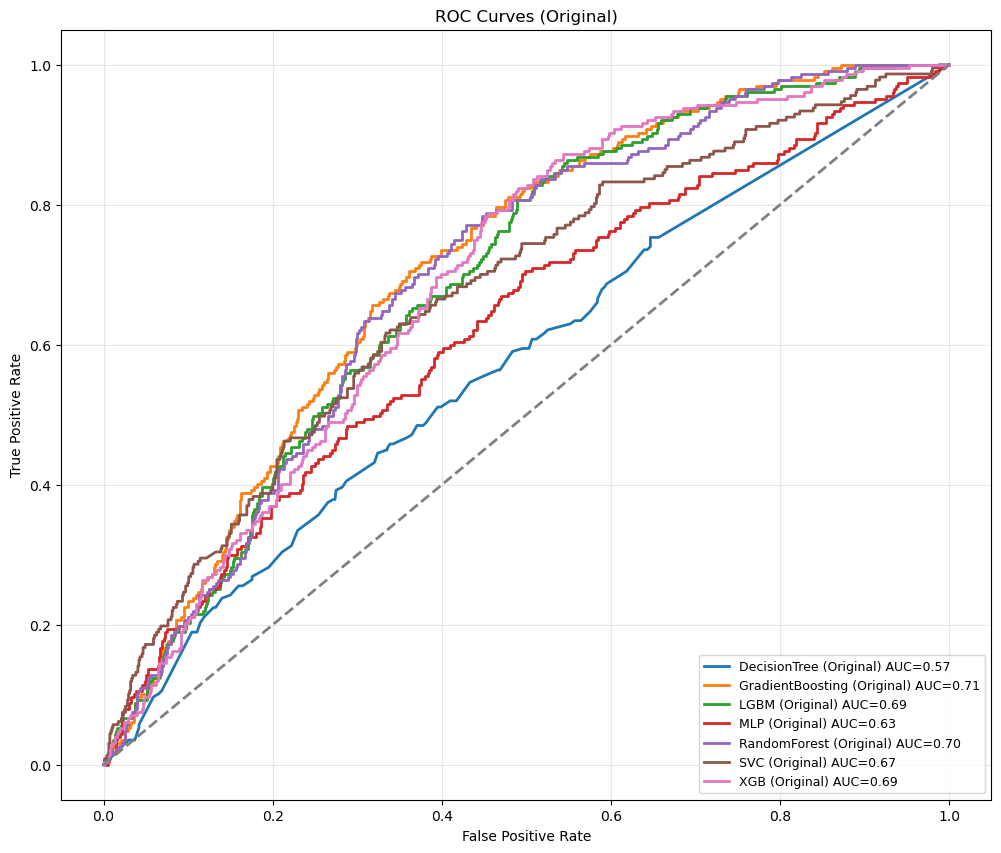

In [70]:
# Plot ROC curves for the holdout test set
plot_comparison_roc(models_orig, X_test, y_test, dataset_label="Original")

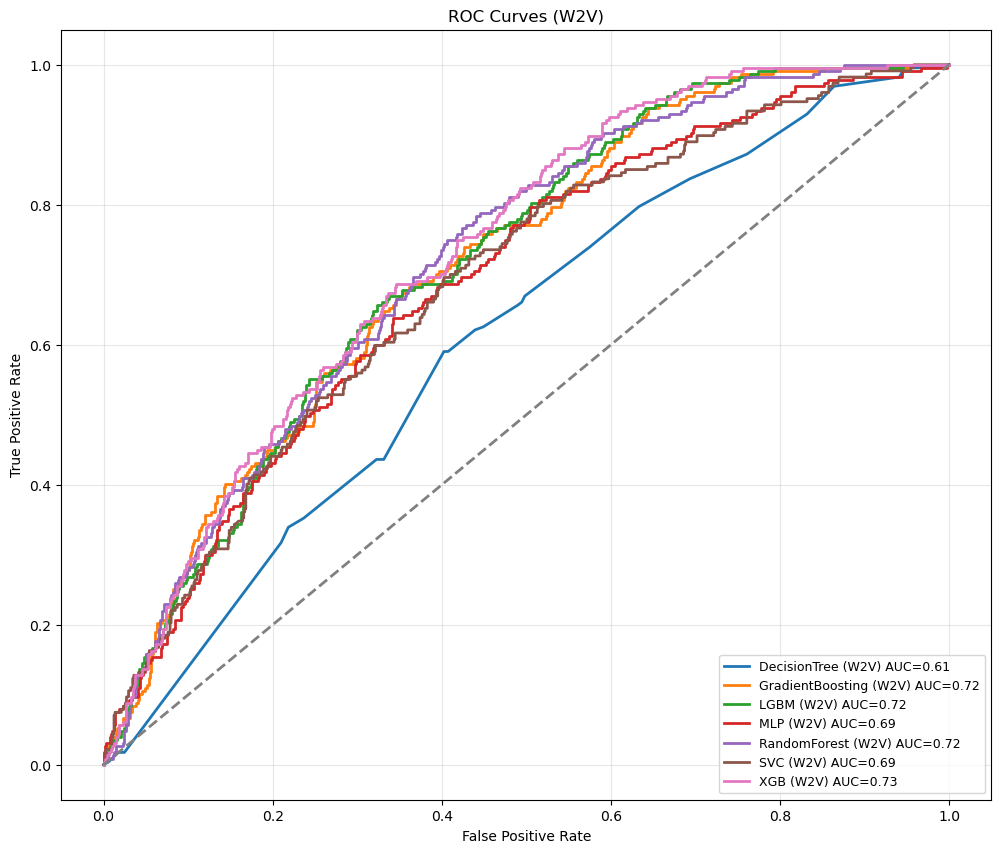

In [71]:
# Plot ROC curves for the holdout test set
plot_comparison_roc(models_w2v, X_test_w2v, y_test_w2v, dataset_label="W2V")

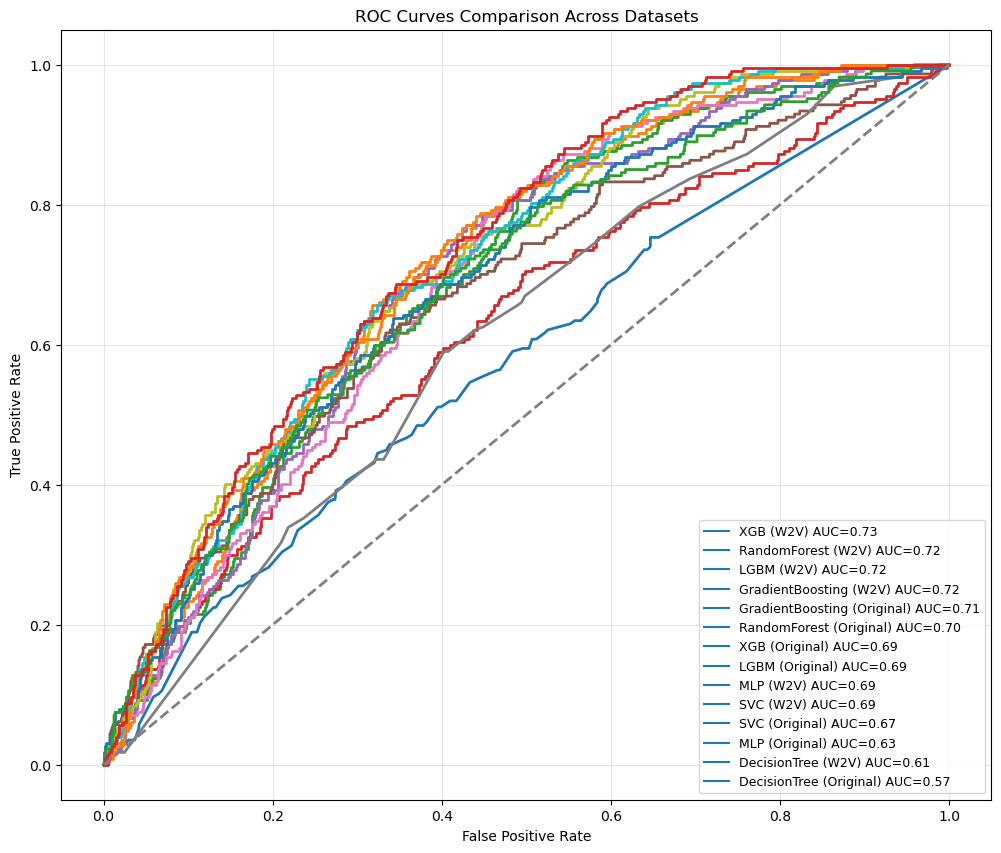

In [72]:
# Compare ROC curves across datasets
plot_comparison_roc_across_datasets(
    models_dicts=[models_orig, models_w2v], #[, models_bert],
    dataset_labels=["Original", "W2V"], # [, "BERT"]
    X_tests=[X_test, X_test_w2v], #[, X_test_bert]
    y_tests=[y_test, y_test_w2v] #[, y_test_bert]
)

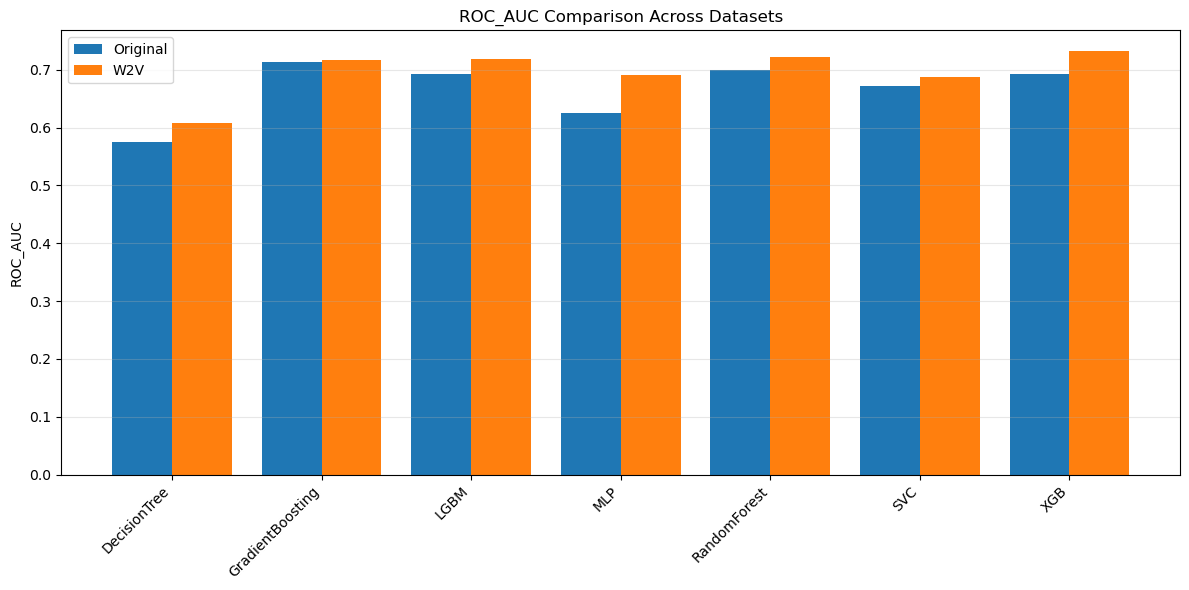

In [73]:
# Compare holdout ROC-AUCs across datasets
plot_holdout_comparison_from_models(
    all_loaded_models=[models_orig, models_w2v], #[ models_bert],
    dataset_labels=["Original", "W2V"], #["BERT"],
    X_tests=[X_test, X_test_w2v], #[, X_test_bert],
    y_tests=[y_test, y_test_w2v], #[, y_test_bert],
    metric="roc_auc"
)

# **Feature Importance & SHAP Value**

## Retrain Smote Models

### Function to Retrain Final Smote

In [74]:
from sklearn.base import clone

def retrain_on_smote(results_dict, model_name, X_train_smote, y_train_smote):
    """
    Retrain a CV-selected classifier on full SMOTE training data.
    Works for all classifiers, tree-based or not.
    """
    if model_name not in results_dict:
        raise ValueError(f"Model '{model_name}' not in results_dict.")
    
    # Clone the pipeline from repeated CV
    pipe = clone(results_dict[model_name]['best_estimator'])
    
    # Remove SMOTE step if present (already done in X_train_smote)
    if 'smote' in pipe.named_steps:
        pipe.steps = [step for step in pipe.steps if step[0] != 'smote']
    
    # Fit on full SMOTE dataset
    pipe.fit(X_train_smote, y_train_smote)
    
    return pipe


#### Retrain Original Models on SMOTE Training

In [75]:
# Dictionary to store retrained models
retrained_models_smote = {}

for name in classifiers.keys():
    try:
        print(f"\n🔹 Retraining {name} on full SMOTE data...")
        retrained_models_smote[name] = retrain_on_smote(results_orig, name, X_train_smote, y_train_smote)
        print(f"✅ {name} retrained successfully.")
    except Exception as e:
        print(f"❌ Error retraining {name}: {e}")


🔹 Retraining SVC on full SMOTE data...
✅ SVC retrained successfully.

🔹 Retraining DecisionTree on full SMOTE data...
✅ DecisionTree retrained successfully.

🔹 Retraining RandomForest on full SMOTE data...
✅ RandomForest retrained successfully.

🔹 Retraining GradientBoosting on full SMOTE data...
✅ GradientBoosting retrained successfully.

🔹 Retraining MLP on full SMOTE data...
✅ MLP retrained successfully.

🔹 Retraining XGB on full SMOTE data...
✅ XGB retrained successfully.

🔹 Retraining LGBM on full SMOTE data...
✅ LGBM retrained successfully.


#### Retrain W2V Models on SMOTE Training

In [76]:
# Dictionary to store retrained models
retrained_models_w2v_smote = {}

for name in classifiers.keys():
    try:
        print(f"\n🔹 Retraining {name} on full SMOTE data...")
        retrained_models_w2v_smote[name] = retrain_on_smote(results_w2v, name, X_train_smote_w2v, y_train_smote_w2v)
        print(f"✅ {name} retrained successfully.")
    except Exception as e:
        print(f"❌ Error retraining {name}: {e}")


🔹 Retraining SVC on full SMOTE data...
✅ SVC retrained successfully.

🔹 Retraining DecisionTree on full SMOTE data...
✅ DecisionTree retrained successfully.

🔹 Retraining RandomForest on full SMOTE data...
✅ RandomForest retrained successfully.

🔹 Retraining GradientBoosting on full SMOTE data...
✅ GradientBoosting retrained successfully.

🔹 Retraining MLP on full SMOTE data...
✅ MLP retrained successfully.

🔹 Retraining XGB on full SMOTE data...
✅ XGB retrained successfully.

🔹 Retraining LGBM on full SMOTE data...
✅ LGBM retrained successfully.


## Feature Importance

In [ ]:
'''
# AC w/ edits

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to your data (replace X_smote and y_smote with your data)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of the features (replace feature_names with your actual feature names)
feature_names = X_train.columns  # Replace with your feature names

# Sort feature importances and feature names in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx][:15]  # Select the top 15 feature importances
sorted_feature_names = [feature_names[i] for i in sorted_idx][:15]  # Select the corresponding feature names

# Create a vertical bar plot with different colors for each feature
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color=plt.cm.Paired(np.arange(len(sorted_feature_names))))
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

'''

#### Feature Importance Wrapper Function

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_features(tree_model_pipe, top_n=15):
    """
    Plot top N feature importances for a retrained tree-based pipeline.
    Skips non-tree models.
    """
    clf = tree_model_pipe.named_steps['clf']

    if not hasattr(clf, 'feature_importances_'):
        raise TypeError(f"{type(clf).__name__} does not support feature_importances_")
    
    # Feature names
    if hasattr(tree_model_pipe.named_steps['scaler'], 'feature_names_in_'):
        feature_names = tree_model_pipe.named_steps['scaler'].feature_names_in_
    elif hasattr(clf, 'feature_names_in_'):
        feature_names = clf.feature_names_in_
    else:
        feature_names = [f'feature_{i}' for i in range(clf.n_features_in_)]
    
    importances = clf.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df = fi_df.sort_values(by='importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(8,6))
    plt.barh(fi_df['feature'][::-1], fi_df['importance'][::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances: {type(clf).__name__}")
    plt.tight_layout()
    plt.show()

#### Compare Feature Importances for Original vs W2V for XGB

In [ ]:
# --- Top-15 feature importance for XGB ---
plot_top_features(retrained_models_smote['XGB'], top_n=30)

In [ ]:
plot_top_features(retrained_models_w2v_smote['XGB'], top_n=30)

#### Compare Feature Importances for Original vs W2V for Random Forest

In [ ]:
# --- Top-15 feature importance for Random Forest ---
plot_top_features(retrained_models_smote['RandomForest'], top_n=15)

In [ ]:
plot_top_features(retrained_models_w2v_smote['RandomForest'], top_n=30)

### SHAP Method

In [ ]:
import shap

def plot_shap_features(tree_model_pipe, X_sample, top_n=15):
    """
    Plot SHAP summary for a retrained tree-based pipeline.
    Skips non-tree models.
    """
    clf = tree_model_pipe.named_steps['clf']

    if not hasattr(clf, 'feature_importances_'):
        raise TypeError(f"{type(clf).__name__} does not support SHAP feature importance")
    
    explainer = shap.Explainer(clf, X_sample)
    shap_values = explainer(X_sample)
    
    shap.summary_plot(shap_values, X_sample, max_display=top_n, plot_type='bar')

In [ ]:
# --- SHAP summary plot - Original XGB ---
plot_shap_features(retrained_models_smote['XGB'], X_sample=X_train_smote, top_n=15)

In [ ]:
# --- SHAP summary plot - Original RandomForest ---
plot_shap_features(retrained_models_smote['RandomForest'], X_sample=X_train_smote, top_n=15)

In [ ]:
# --- SHAP summary plot - W2V XGB ---
plot_shap_features(retrained_models_w2v_smote['XGB'], X_sample=X_train_smote_w2v, top_n=15)

In [ ]:
# --- SHAP summary plot - W2V RandomForest ---
plot_shap_features(retrained_w2v_models_smote['RandomForest'], X_sample=X_train_smote_w2v, top_n=15)

In [ ]:
'''
# AC w/ edits

model = classifiers['RandomForest'].fit(X_smote, y_smote)

# pip install shap
import shap

explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

X_test

shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.bar(shap_values[1])
'''

# Statistical Tests

## Delong's Test

In [130]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# ---- DeLong (from our earlier step) ----
from scipy.stats import norm

def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    n = len(x)
    T = np.zeros(n, dtype=float)
    i = 0
    while i < n:
        j = i
        while j < n and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i+j-1) + 1
        i = j
    T2 = np.empty(n, dtype=float)
    T2[J] = T
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    pos_preds = predictions_sorted_transposed[:, :m]
    neg_preds = predictions_sorted_transposed[:, m:]

    tx = np.empty((2, m))
    ty = np.empty((2, n))
    for r in range(2):
        tx[r] = compute_midrank(pos_preds[r])
        ty[r] = compute_midrank(neg_preds[r])

    tz = np.hstack((pos_preds, neg_preds))
    T = np.empty((2, m+n))
    for r in range(2):
        T[r] = compute_midrank(tz[r])

    aucs = T[:, :m].sum(axis=1) / (m*n) - (m+1.0)/(2*n)
    v01 = (T[:, :m] - tx) / n
    v10 = 1 - (T[:, m:] - ty) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    s = sx/m + sy/n
    return aucs, s

def calc_pvalue(aucs, s):
    diff = aucs[0] - aucs[1]
    var = s[0,0] + s[1,1] - 2*s[0,1]
    z = np.abs(diff)/np.sqrt(var)
    p = 2*norm.sf(z)
    return diff, p

def delong_roc_test(y_true, y_pred1, y_pred2):
    # Ensure numpy arrays
    y_true = np.array(y_true).astype(int)
    y_pred1 = np.array(y_pred1, dtype=float)
    y_pred2 = np.array(y_pred2, dtype=float)

    # ---- Sort by labels (positives first) instead of predictions ----
    order = np.argsort(-y_true)
    y_true_sorted = y_true[order]
    preds = np.vstack((y_pred1, y_pred2))[:, order]

    label_1_count = int(np.sum(y_true_sorted))
    aucs, s = fastDeLong(preds, label_1_count)
    diff, p = calc_pvalue(aucs, s)
    return aucs, diff, p

'''
def delong_test(y_true, y_pred1, y_pred2):
    """Wrapper around DeLong to return scalar AUROCs, difference, and p-value"""
    order = np.argsort(-y_pred1)
    y_true = np.array(y_true)[order]
    preds = np.vstack((y_pred1, y_pred2))[:, order]
    label_1_count = np.sum(y_true)

    aucs, s = fastDeLong(preds, int(label_1_count))
    diff, p = calc_pvalue(aucs, s)

    auc1, auc2 = aucs
    return float(auc1), float(auc2), float(diff), float(p)
'''    

'\ndef delong_test(y_true, y_pred1, y_pred2):\n    """Wrapper around DeLong to return scalar AUROCs, difference, and p-value"""\n    order = np.argsort(-y_pred1)\n    y_true = np.array(y_true)[order]\n    preds = np.vstack((y_pred1, y_pred2))[:, order]\n    label_1_count = np.sum(y_true)\n\n    aucs, s = fastDeLong(preds, int(label_1_count))\n    diff, p = calc_pvalue(aucs, s)\n\n    auc1, auc2 = aucs\n    return float(auc1), float(auc2), float(diff), float(p)\n'

### Get y_preds

In [127]:
# Get predicted probabilities on the external holdout set for original
y_pred_best_orig = best_orig_smote_model.predict_proba(X_test)[:, 1]

# (Optional) AUROC check
from sklearn.metrics import roc_auc_score
print("GradientBoosting (Orig+SMOTE) AUROC:", roc_auc_score(y_test, y_pred_best_orig))

GradientBoosting (Orig+SMOTE) AUROC: 0.7126996567660334


In [128]:
# Get predicted probabilities on the external holdout set for w2v
y_pred_best_w2v = best_w2v_smote_model.predict_proba(X_test_w2v)[:, 1]

# (Optional) AUROC check
from sklearn.metrics import roc_auc_score
print("ExtremeGradientBoosting (Orig+SMOTE+W2V) AUROC:", roc_auc_score(y_test, y_pred_best_w2v))

ExtremeGradientBoosting (Orig+SMOTE+W2V) AUROC: 0.7317045485257155


### Run Delong Test to Test Best Classifiers

In [131]:
from sklearn.metrics import roc_auc_score

# holdout AUROCs
auc_orig = roc_auc_score(y_true_np, y_pred_best_orig_np)
auc_w2v  = roc_auc_score(y_true_np, y_pred_best_w2v_np)

# statistical test
aucs, diff, p = delong_roc_test(y_true_np, y_pred_best_orig_np, y_pred_best_w2v_np)

print(f"AUROC_orig = {auc_orig:.3f}")
print(f"AUROC_w2v  = {auc_w2v:.3f}")
print(f"ΔAUROC (w2v-orig) = {auc_w2v - auc_orig:.3f}")
print(f"P-value (DeLong) = {p:.4f}")

AUROC_orig = 0.713
AUROC_w2v  = 0.732
ΔAUROC (w2v-orig) = 0.019
P-value (DeLong) = 0.1919


### Run Delong Test to Test Classifiers Head-to-Head

In [132]:
# ---- Run comparisons across classifiers ----
results = []

for clf in retrained_models_smote.keys():
    # Predictions
    y_pred_orig = retrained_models_smote[clf].predict_proba(X_test)[:, 1]
    y_pred_w2v  = retrained_models_w2v_smote[clf].predict_proba(X_test_w2v)[:, 1]

    # Holdout AUROC
    auc_orig = roc_auc_score(y_test, y_pred_orig)
    auc_w2v  = roc_auc_score(y_test, y_pred_w2v)

    # DeLong test
    aucs, diff, p = delong_roc_test(y_test.values, np.array(y_pred_orig), np.array(y_pred_w2v))

    results.append({
        "Classifier": clf,
        "AUROC_orig": auc_orig,
        "AUROC_w2v": auc_w2v,
        "ΔAUROC (w2v-orig)": auc_w2v - auc_orig,
        "p-value": p
    })

# ---- Make results table ----
results_df = pd.DataFrame(results)

# Sort by p-value ascending
results_df = results_df.sort_values("p-value").reset_index(drop=True)

print(results_df.to_string(index=False))

      Classifier  AUROC_orig  AUROC_w2v  ΔAUROC (w2v-orig)  p-value
             MLP    0.625778   0.691338           0.065560 0.004159
             XGB    0.693333   0.731705           0.038372 0.010463
    RandomForest    0.699322   0.722343           0.023021 0.099460
            LGBM    0.693197   0.718672           0.025475 0.110423
    DecisionTree    0.574501   0.608654           0.034153 0.198646
             SVC    0.672755   0.688287           0.015532 0.255295
GradientBoosting    0.712700   0.716694           0.003994 0.788185


In [ ]:
# AC w/ edits

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

# Assuming scaled_w2v is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(scaled_w2v, test_size=0.2)  # For example, 80% training, 20% test

# Select the numeric columns you want to compare
numeric_cols = [
    'los_icu', 'max_age', 'sofa_score', 'avg_urineoutput',  'glucose_min', 'glucose_max',
    'glucose_average', 'sodium_min', 'sodium_max', 'sodium_average',
    'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min',
    'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'resp_rate_min',
    'resp_rate_max', 'resp_rate_mean', 'spo2_min', 'spo2_max', 'spo2_mean'
]

# NOTE PUT 'temperature_min', 'temperature_max', 'temperature_avg', back into the above numeric columns after fixing sql query!!!

# Initialize a DataFrame to store p-values and means
comparison = pd.DataFrame(index=numeric_cols, columns=['Train Mean', 'Test Mean', 'P-Value'])

# Calculate p-values and means for each variable between train and test sets
for col in numeric_cols:
    train_mean = train[col].dropna().mean()
    test_mean = test[col].dropna().mean()
    p_value = stats.ttest_ind(train[col].dropna(), test[col].dropna(), equal_var=False).pvalue

    comparison.loc[col, 'Train Mean'] = train_mean
    comparison.loc[col, 'Test Mean'] = test_mean
    comparison.loc[col, 'P-Value'] = p_value

# Print the resulting DataFrame with means and p-values
print(comparison)


In [ ]:
# AC w/ edits

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

# Assuming scaled_w2v is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(scaled_w2v, test_size=0.2)  # For example, 80% training, 20% test

# Select the categorical columns you want to compare
categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids','renal_disease',
    'antibiotic_Vancomycin','antibiotic_Vancomycin Antibiotic Lock', 
    'antibiotic_Vancomycin Enema','antibiotic_Vancomycin Intrathecal',
    'antibiotic_Vancomycin Oral Liquid',
    'gender_F'
]

"""
NOTE Use the below when the sql query is fixed!!!
categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids',
    'renal_disease','antibiotic_Carbapenem','antibiotic_Aminoglycoside',
    'antibiotic_Glycopeptide','antibiotic_Oxazolidinone','antibiotic_Penicillin',
    'antibiotic_Sulfonamide','antibiotic_Tetracycline','gender_F'
]
"""

# Initialize a DataFrame to store Chi-Square p-values and percentage of ones
comparison = pd.DataFrame(index=categorical_cols, columns=['Chi-Square P-Value', 'Percentage of Ones'])

# Calculate Chi-Square p-values and percentage of ones for each categorical variable between train and test sets
for col in categorical_cols:
    train_values = train[col].value_counts()
    test_values = test[col].value_counts()

    # Create a set of all unique categories across both train and test sets
    all_categories = set(train_values.index) | set(test_values.index)

    # Ensure that both train and test sets have counts for all categories
    train_values = train_values.reindex(all_categories, fill_value=0)
    test_values = test_values.reindex(all_categories, fill_value=0)

    # Create a contingency table
    contingency_table = pd.DataFrame({'Train': train_values, 'Test': test_values})

    # Calculate Chi-Square p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Calculate the percentage of ones in the test set
    total_ones_test = test_values.get(1, 0)
    total_values_test = test_values.sum()
    percentage_ones = (total_ones_test / total_values_test) * 100

    comparison.loc[col, 'Chi-Square P-Value'] = p
    comparison.loc[col, 'Percentage of Ones'] = percentage_ones

# Print the resulting DataFrame with Chi-Square p-values and percentage of ones
print(comparison)


In [ ]:
# AC w/ edits

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

# Assuming scaled_w2v is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(scaled_w2v, test_size=0.2)  # For example, 80% training, 20% test

# Select the categorical columns you want to compare

categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids','renal_disease',
    'antibiotic_Vancomycin','antibiotic_Vancomycin Antibiotic Lock', 
    'antibiotic_Vancomycin Enema','antibiotic_Vancomycin Intrathecal',
    'antibiotic_Vancomycin Oral Liquid',
    'gender_F'
]
"""
NOTE Use the below when the sql query is fixed!!!
categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids',
    'renal_disease','antibiotic_Carbapenem','antibiotic_Aminoglycoside',
    'antibiotic_Glycopeptide','antibiotic_Oxazolidinone','antibiotic_Penicillin',
    'antibiotic_Sulfonamide','antibiotic_Tetracycline','gender_F'
]
"""

# Initialize a DataFrame to store Chi-Square p-values and percentage of ones
comparison = pd.DataFrame(index=categorical_cols, columns=['Chi-Square P-Value', 'Percentage of Ones (Train)', 'Percentage of Ones (Test)'])

# Calculate Chi-Square p-values, train percentages of ones, and test percentages of ones for each categorical variable
for col in categorical_cols:
    train_values = train[col].value_counts()
    test_values = test[col].value_counts()

    # Create a set of all unique categories across both train and test sets
    all_categories = set(train_values.index) | set(test_values.index)

    # Ensure that both train and test sets have counts for all categories
    train_values = train_values.reindex(all_categories, fill_value=0)
    test_values = test_values.reindex(all_categories, fill_value=0)

    # Create a contingency table
    contingency_table = pd.DataFrame({'Train': train_values, 'Test': test_values})

    # Calculate Chi-Square p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Calculate the percentage of ones in train and test sets
    train_percentage_ones = (train[col] == 1).sum() / len(train) * 100
    test_percentage_ones = (test[col] == 1).sum() / len(test) * 100

    comparison.loc[col, 'Chi-Square P-Value'] = p
    comparison.loc[col, 'Percentage of Ones (Train)'] = train_percentage_ones
    comparison.loc[col, 'Percentage of Ones (Test)'] = test_percentage_ones

# Print the resulting DataFrame with Chi-Square p-values and percentages of ones in train and test sets
print(comparison)


# Summary Table

In [ ]:
# AC w/ edits

import pandas as pd

# Assuming scaled_w2v is already loaded into the workspace

# Generate a statistical summary for both numeric and categorical columns
summary = df.describe(include='all')

# Print the summary statistics
print(summary)
